In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# LINE-M Assumptions
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

# Advanced Time Series models
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# For SARIMA model:
from pmdarima.utils import tsdisplay, plot_acf, plot_pacf
import pmdarima as pmd

import warnings
warnings.filterwarnings("ignore")

---

## Importing & Preprocessing the TSLA dataset

In [2]:
df = pd.read_csv('../data/df_tsla_pricing.csv')

In [3]:
print(df.shape)
df.head()

(146, 3)


,Date,Closing_Prices,Weekly_Volume
0,2021-01-01,272.013336,531246900
1,2021-01-08,281.666656,735619800
2,2021-01-15,281.663330,330994800
3,2021-01-22,278.476654,414250500
4,2021-01-29,283.329987,356653800


In [4]:
df.columns = df.columns.str.lower()
df.rename(columns={'closing_prices': 'close', 'weekly_volume': 'volume'}, inplace=True)

In [5]:
df.head()

,date,close,volume
0,2021-01-01,272.013336,531246900
1,2021-01-08,281.666656,735619800
2,2021-01-15,281.663330,330994800
3,2021-01-22,278.476654,414250500
4,2021-01-29,283.329987,356653800


In [6]:
# Convert time period to datetime format
df['date'] = pd.to_datetime(df['date']) # Shows weekly data

In [7]:
# Set and sort index
df.set_index('date', inplace = True)
df.sort_index(inplace = True)

---

## Instantiating the Starting Linear Regression Model:

In [8]:
# Make the data numeric
X = pd.to_numeric(df.index)
X = X.to_numpy().reshape(-1, 1)
y = df['close']

In [9]:
X[:5]

array([[1609459200000000000],
       [1610064000000000000],
       [1610668800000000000],
       [1611273600000000000],
       [1611878400000000000]])

In [10]:
y[:5]

date
2021-01-01    272.013336
2021-01-08    281.666656
2021-01-15    281.663330
2021-01-22    278.476654
2021-01-29    283.329987
Name: close, dtype: float64

In [11]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [12]:
preds = lr.predict(X)

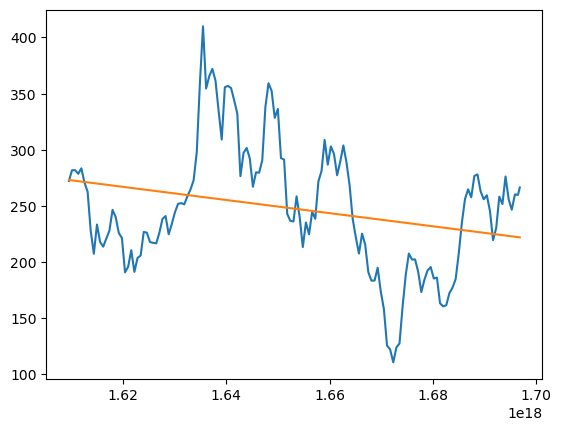

In [13]:
plt.plot(X, y);
plt.plot(X, preds);

plt.show()

Differencing or detrending is a common preprocessing step in time series analysis with several important purposes:

1. Stabilizing the Variance
2. Removing Seasonality
3. Transforming a non-stationary series into a stationary one
4. Highlighting Trends more apparently
5. Residual Analysis
6. Improving Model Performance

It's important to note that the choice of differencing or detrending method depends on the specific characteristics of the time series data. Some time series may require first-order differencing, while others may need higher-order differencing or more complex detrending techniques.

In [14]:
# Option 1- Detrending:
detrended = y - preds
detrended

date
2021-01-01    -0.930690
2021-01-08     9.076564
2021-01-15     9.427171
2021-01-22     6.594428
2021-01-29    11.801694
                ...    
2023-09-15    32.660595
2023-09-22    23.694537
2023-09-29    37.718453
2023-10-06    37.692412
2023-10-10    44.524634
Name: close, Length: 146, dtype: float64

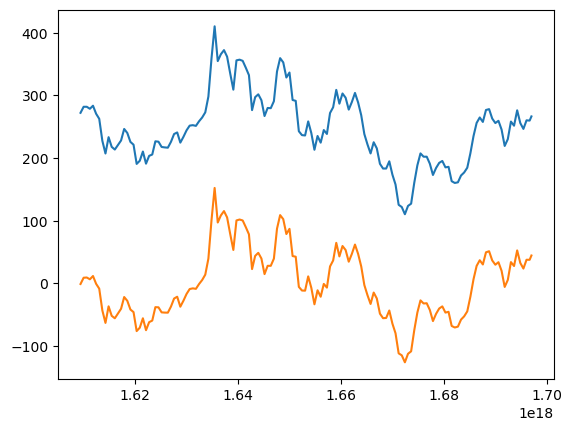

In [15]:
plt.plot(X, y);
plt.plot(X, detrended);

In [16]:
# Option 2 - Differencing 
df['difference'] = df['close'].diff()
df.head(10)

,close,volume,difference
date,,,
2021-01-01,272.013336,531246900,NaN
2021-01-08,281.666656,735619800,9.653320
2021-01-15,281.663330,330994800,-0.003326
2021-01-22,278.476654,414250500,-3.186676
2021-01-29,283.329987,356653800,4.853333
2021-02-05,270.553345,335174700,-12.776642
2021-02-12,262.459991,262572600,-8.093353
2021-02-19,227.406662,595877400,-35.053329
2021-02-26,207.146667,564255300,-20.259995


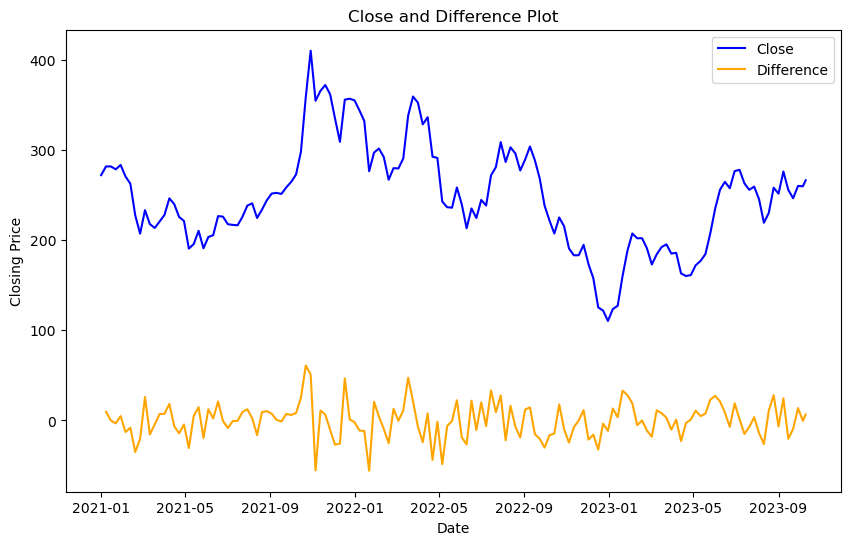

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'close' column
ax.plot(df.index, df['close'], label='Close', color='blue')

# Plot 'difference' column
ax.plot(df.index, df['difference'], label='Difference', color='orange')

# Set title, labels, and legend
ax.set_title('Close and Difference Plot')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend()

# Show the plot
plt.show()

---

## Train/Test Split for All Models:

In [18]:
# Splitting the dataset between the train and testing sets

train = df.loc[:'2023-03-18']
test = df.loc['2023-03-19':]

print(f'Of the 92 weekly entries within the dataframe, an 80/20 split allots {len(train)} entries to the training set and {len(test)} to the testing set.')

Of the 92 weekly entries within the dataframe, an 80/20 split allots 116 entries to the training set and 30 to the testing set.


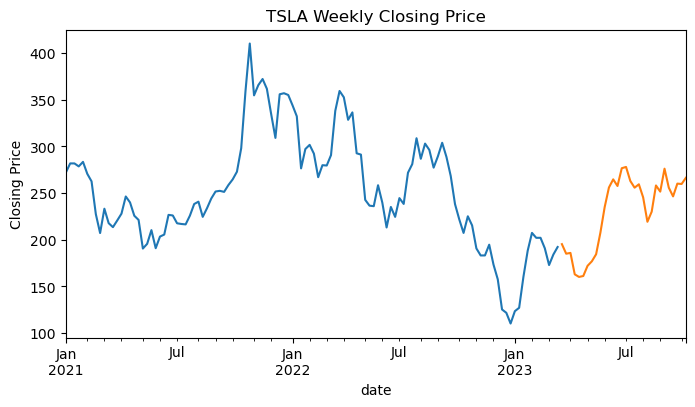

In [19]:
# Plotting both dataframes:
train['close'].plot()
test['close'].plot(figsize = (8, 4), title = 'TSLA Weekly Closing Price');
plt.ylabel('Closing Price');

---

## Model 1: Naive Forecast

- A naive forecast, also known as the persistence model, is a simple time series forecasting method that assumes that future values will be the same as the most recent observed value. It doesn't consider any trend, seasonality, or other factors, making it a straightforward but often inaccurate forecasting approach for complex time series data.
$${\Large \hat y_{t+1} = y_t}$$


In [20]:
# Creating a predictions df where the predicted values equal the last closing price in the TSLA df:

df_preds = test.copy(deep = True) 
df_preds['last'] = train['close'].iloc[-1]
df_preds.head()

,close,volume,difference,last
date,,,,
2023-03-24,195.279999,569730800,3.059998,192.220001
2023-03-31,185.059998,723972200,-10.220001,192.220001
2023-04-07,185.899994,521114800,0.839996,192.220001
2023-04-14,162.990005,641871400,-22.909988,192.220001
2023-04-21,160.190002,665924200,-2.800003,192.220001


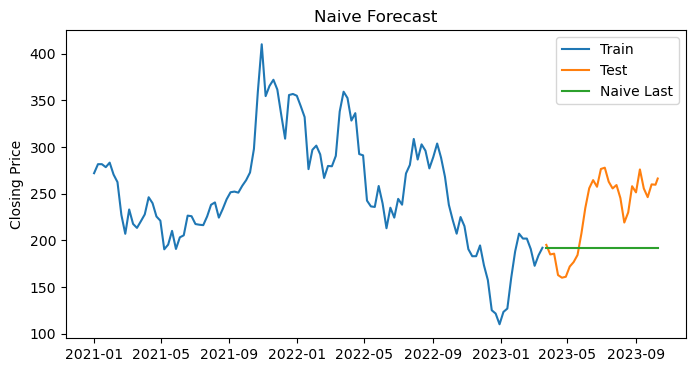

In [21]:
# Plotting the historic data, the actual "future" data, and the predicted "future" data.

plt.figure(figsize = (8, 4))

plt.plot(train.index, train['close'], label = 'Train')
plt.plot(test.index, test['close'], label = 'Test')
plt.plot(df_preds.index, df_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.title('Naive Forecast');
plt.ylabel('Closing Price');

In [22]:
# Score the model: RMSE
mean_squared_error(df_preds['close'], df_preds['last'], squared = False)

54.37266644417247

Root Mean Squared Error (RMSE) is a commonly used metric in statistics and machine learning to measure the accuracy of a predictive model. It calculates the square root of the average of the squared differences between predicted and actual values, providing a single value that represents the typical error between predictions and true observations, with lower RMSE values indicating better model accuracy. This RMSE will be compared to those of later models to determine best fit.

---

## Model 2: Historic Mean of the Training Data
- A model predicting the historic mean of the training data is a simple forecasting approach where the model assumes that future values will be the same as the historical average of the training dataset. It implies that the model expects no trend or seasonality in the data and provides a straightforward but often limited baseline for prediction.

In [23]:
# Adding a column to the df_preds for the simple average:
df_preds['simple_mean'] = train['close'].mean()
df_preds.head()

,close,volume,difference,last,simple_mean
date,,,,,
2023-03-24,195.279999,569730800,3.059998,192.220001,251.710891
2023-03-31,185.059998,723972200,-10.220001,192.220001,251.710891
2023-04-07,185.899994,521114800,0.839996,192.220001,251.710891
2023-04-14,162.990005,641871400,-22.909988,192.220001,251.710891
2023-04-21,160.190002,665924200,-2.800003,192.220001,251.710891


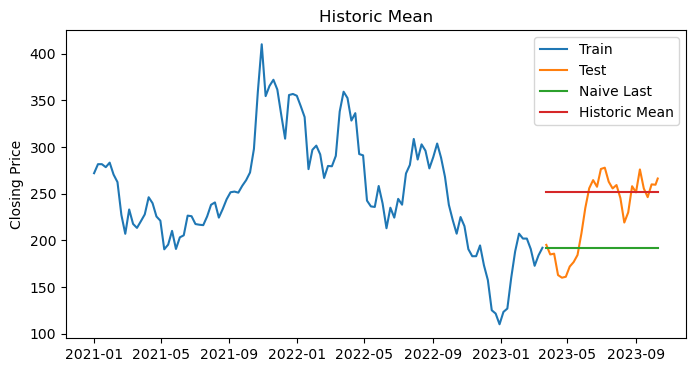

In [24]:
# Add the simple average to the plot above:
plt.figure(figsize = (8, 4))

plt.plot(train.index, train['close'], label = 'Train')
plt.plot(test.index, test['close'], label = 'Test')
plt.plot(df_preds.index, df_preds['last'], label = 'Naive Last')
plt.plot(df_preds.index, df_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.title('Historic Mean');
plt.ylabel('Closing Price');

In [25]:
# Score the model: RMSE
mean_squared_error(df_preds['close'], df_preds['simple_mean'], squared = False)

44.49803998347334

This RMSE is lower than that of the Naive forecast, as predicted.

---

## Model 3: Simple Exponential Smoothing

- Simple exponential smoothing is a time series forecasting method that assigns exponentially decreasing weights to past observations, with more recent data receiving higher importance. It is a straightforward technique that essentially finds a moving average. It is suitable for data with no significant trends or seasonality.
- It forecasts future values by giving greater weight to recent observations (through the parameter α, which is between 0 and 1) while smoothing out random noise in the data. Therefore older values matter less.


$${\Large\hat y_{t+1} = \alpha y_t + \alpha (1-\alpha)y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} + ...}$$

In [26]:
ses = SimpleExpSmoothing(train['close']).fit(smoothing_level = .5)

In [27]:
# Summary info:of
ses.summary()

Dep. Variable:,close,No. Observations:,116
Model:,SimpleExpSmoothing,SSE,69243.267
Optimized:,True,AIC,745.448
Trend:,None,BIC,750.955
Seasonal:,None,AICC,745.808
Seasonal Periods:,None,Date:,"Tue, 10 Oct 2023"
Box-Cox:,False,Time:,12:29:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,275.90238,l.0,True


The SES summary output table supplies many parameters to interpret. The primary focus here is as follows:
- the AIC and BIC outputs for model selection
- parameter estimates (such as the smoothing coefficient alpha)
- the model's ability to capture underlying patterns in the data.

AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are statistical measures used to evaluate the goodness of fit of a model while penalizing for model complexity. In the context of time series forecasting, a lower AIC or BIC indicates a better-fitting model. Therefore, when interpreting the results of `ses.summary()`, the AIC and BIC values are similar at ~745 and 751, respectively. If comparing many SES models, the best selection is the model with the lowest AIC and BIC values as it suggests the best trade-off between model accuracy and complexity.

Apart from AIC and BIC, some other important pieces of information in the summary output of a time series model include:

1. Parameter Estimates: In this SES model, alpha is set to 0.5. Exploring different values for that smoothing coefficient determined how much weight recent observations receive and the level of noise in the data, thereby changing the model. 
1. Model Fit Statistics such as Sum of the Squares of the Errors (SSE). These statistics quantify the model's accuracy in predicting the data. Smaller values (relative to competing models) indicate better accuracy. Here the SES is 69,243.

In [28]:
# Forecast
ses.forecast()

2023-03-24    188.072823
Freq: W-FRI, dtype: float64

- SES forecasts the same number every time, so this isn't going to be a winner.

In [29]:
# Adding a column to the df_preds for the simple exponential smoothing:
df_preds['ses'] = ses.forecast(len(test))
df_preds.head()

,close,volume,difference,last,simple_mean,ses
date,,,,,,
2023-03-24,195.279999,569730800,3.059998,192.220001,251.710891,188.072823
2023-03-31,185.059998,723972200,-10.220001,192.220001,251.710891,188.072823
2023-04-07,185.899994,521114800,0.839996,192.220001,251.710891,188.072823
2023-04-14,162.990005,641871400,-22.909988,192.220001,251.710891,188.072823
2023-04-21,160.190002,665924200,-2.800003,192.220001,251.710891,188.072823


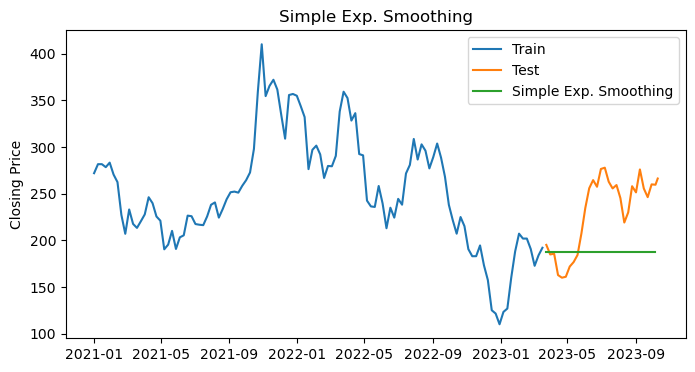

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(train.index, train['close'], label = 'Train')
plt.plot(test.index, test['close'], label = 'Test')
plt.plot(df_preds.index, df_preds['ses'], label = 'Simple Exp. Smoothing')

plt.legend(loc = 'best')
plt.title('Simple Exp. Smoothing');
plt.ylabel('Closing Price');

In [31]:
# There is 1 missing value is 'ses.' Therfore drop that row
df_preds.dropna(subset=['ses'], inplace=True)

# Score the model: RMSE
mean_squared_error(df_preds['close'], df_preds['ses'], squared = False)

56.486636071098744

---

## Model 4: Holt-Winters' (additive and multiplicative versions)

- Holt-Winters' method, also known as the Triple Exponential Smoothing, is a time series forecasting technique that extends simple exponential smoothing to account for seasonality and trends in the data. It consists of three components: level (α), trend (β), and seasonality (γ). By incorporating these components, Holt-Winters' method provides a more robust framework for capturing and forecasting time series data with both seasonally repeating patterns and underlying trends.
- Holt-Winters' can handle treand and seasonality. It weights recent values more than old ones. This is a very strong classical time series model.
- In the code below, we will apply exponential smoothing to the seasonal components as well as the level and trend components.

Here are the constituent parts of the additive model:

$$L_t = \alpha (y_t - S_{t-s}) + (1 - \alpha)(L_{t-1} + b_{t-1})$$
$$b_t = \beta *(L_t - L_{t-1}) + (1 - \beta)b_{t-1}$$
$$S_t = \gamma(y_t-L_t)+(1-\gamma)S_{t-s}$$
Combine these into a single equation:
$${\Large F_{t+k} = L_t + kb_t+S_{t+k-s}}$$
(where α, β, and γ are the smoothing parameters, each between 0 and 1, and s is the length of the seasonal cycle.)

In [32]:
train.index.freq = 'W-FRI' # weekly, Friday

In [33]:
hw = ExponentialSmoothing(train['close'],
                     trend = 'add', # Chose additive
                      seasonal = 'add', # Chose additive
                      seasonal_periods=52).fit()

In [34]:
hw.summary()

Dep. Variable:,close,No. Observations:,116
Model:,ExponentialSmoothing,SSE,24970.965
Optimized:,True,AIC,735.138
Trend:,Additive,BIC,889.339
Seasonal:,Additive,AICC,855.208
Seasonal Periods:,52,Date:,"Tue, 10 Oct 2023"
Box-Cox:,False,Time:,12:29:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9999873,alpha,True
smoothing_trend,7.2529e-05,beta,True


- When interpreting the Holt-Winters' summary chart, several key elements are essential. The "alpha," "beta," and "gamma" values represent the smoothing parameters for level, trend, and seasonality, respectively. Lower values of these parameters indicate greater emphasis on recent observations, while higher values give more weight to historical data.
- Here the AIC and BIC valus are 735 and 889, which are higher (and therefore less desirable) than those in the SES model. The SES here, at 20,599, is lower (and therefore more desirable) than the SES model. Therefore, based on these three parameters, there is not a clear preference between models.

In [35]:
# Adding a column to the df_preds for the hw model
df_preds['hw'] = hw.forecast(len(test))
df_preds.head()

,close,volume,difference,last,simple_mean,ses,hw
date,,,,,,,
2023-03-24,195.279999,569730800,3.059998,192.220001,251.710891,188.072823,206.362221
2023-03-31,185.059998,723972200,-10.220001,192.220001,251.710891,188.072823,206.891318
2023-04-07,185.899994,521114800,0.839996,192.220001,251.710891,188.072823,204.096168
2023-04-14,162.990005,641871400,-22.909988,192.220001,251.710891,188.072823,204.771744
2023-04-21,160.190002,665924200,-2.800003,192.220001,251.710891,188.072823,175.813555


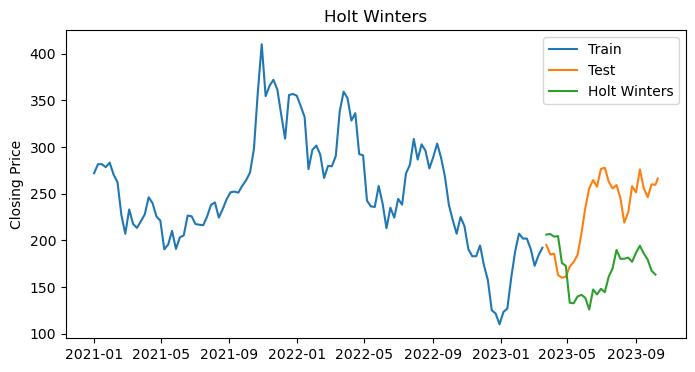

In [36]:
plt.figure(figsize=(8,4))
plt.plot(train.index, train['close'], label = 'Train')
plt.plot(test.index, test['close'], label = 'Test')
plt.plot(df_preds.index, df_preds['hw'], label = 'Holt Winters')

plt.legend(loc = 'best')
plt.title('Holt Winters');
plt.ylabel('Closing Price');

In [37]:
# Score the model: RMSE
mean_squared_error(df_preds['close'], df_preds['hw'], squared = False)

77.70817501035998

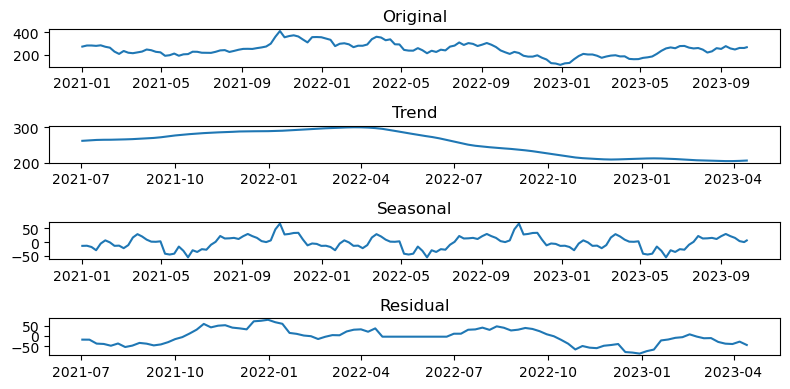

In [38]:
# The time series data I want to decompose:
time_series = df['close']

# Apply seasonal_decompose to the time series
result = sm.tsa.seasonal_decompose(time_series, period=52)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(8, 4))

axes[0].set_title('Original')
axes[0].plot(time_series)

axes[1].set_title('Trend')
axes[1].plot(result.trend)

axes[2].set_title('Seasonal')
axes[2].plot(result.seasonal)

axes[3].set_title('Residual')
axes[3].plot(result.resid)

plt.tight_layout()
plt.show()

In [39]:
# Pickling the HW model:

train.to_pickle('../pickled_models/hw/hw_train.pkl')
test.to_pickle('../pickled_models/hw/hw_test.pkl')
df_preds.to_pickle('../pickled_models/hw/hw_df_predictions.pkl')

---

## Model 5: SARIMA

- A Seasonal Autoregressive Integrated Moving Average (SARIMA) model is a sophisticated time series forecasting method that extends the ARIMA model by incorporating seasonality. It accounts for both the autoregressive (AR) and moving average (MA) components of the data while also considering seasonal patterns. The SARIMA model is defined by three main parameters: (p, d, q) for the non-seasonal component, (P, D, Q, S) for the seasonal component, and a differencing order (d) to make the time series stationary, allowing it to capture both short-term and long-term dependencies in the data.


- An $ARIMA(p, d, q)$ model is specified by:

> - how many lags $p$ we regress $Y_t^{(d)}$ on.
> - how many differences $d$ we need to calculate in order to best achieve stationarity.
> - how many errors $q$ we regress $Y_t^{(d)}$ on.

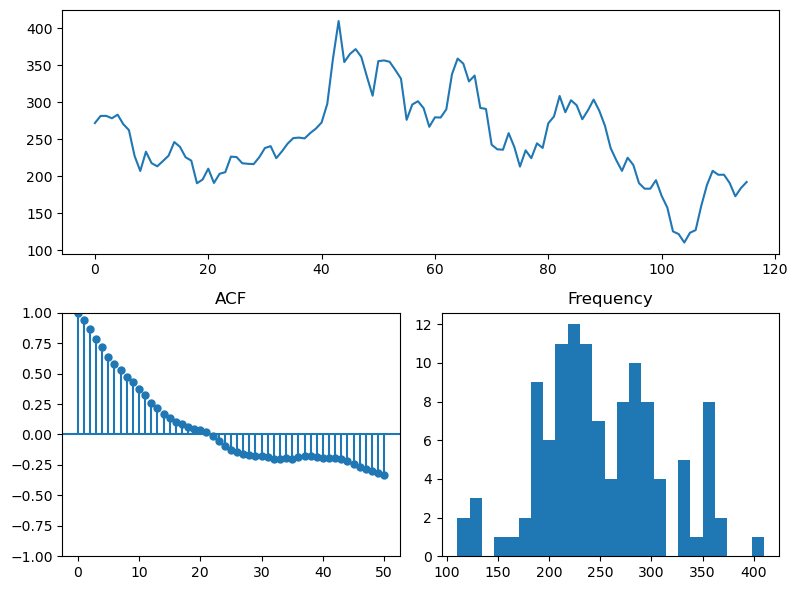

In [40]:
time_series = train['close']

# Use tsdisplay to visualize the time series
tsdisplay(time_series)

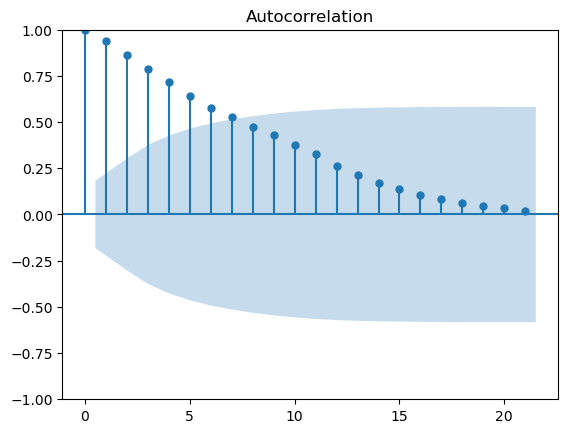

In [41]:
plot_acf(train['close'], alpha = 0.05)

Autocorrelation measures the correlation between a series and its lagged values, with each lag representing a time shift. In this plot:

- Lag values are shown on the x-axis, representing the time lags at which the autocorrelation is calculated.
- The y-axis represents the autocorrelation coefficients, which indicate the strength and direction of the correlation between the original series and its lagged values.
- The horizontal shaded area represent confidence intervals. The significance level (alpha) is set to 0.05, so autocorrelation values outside these intervals are considered statistically significant.

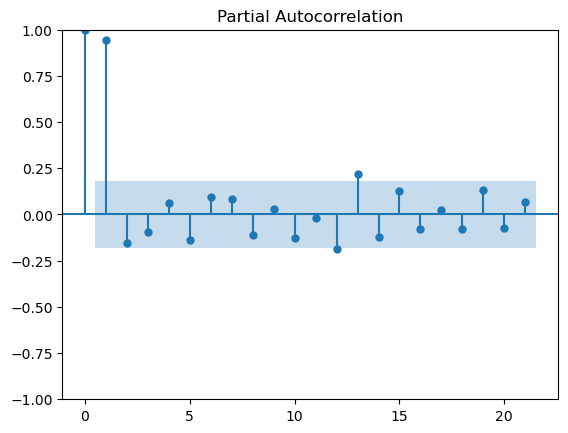

In [42]:
plot_pacf(train['close'], alpha = 0.05)

Partial autocorrelation measures the correlation between a series and its lagged values while controlling for the influence of intermediate lags. In this plot:

- Lag values are shown on the x-axis, representing the time lags at which the partial autocorrelation is calculated.
- The y-axis represents the partial autocorrelation coefficients, which indicate the strength and direction of the partial correlation between the original series and its lagged values.
- The horizontal shaded area represent confidence intervals. The significance level (alpha) is set to 0.05, so partial autocorrelation values outside these intervals are considered statistically significant.

In [43]:
model = pmd.auto_arima(train['close'], m = 52, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.50 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1022.843, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1025.783, Time=0.75 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1025.863, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1020.977, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=1024.745, Time=0.64 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=1024.742, Time=0.42 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1023.888, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1023.962, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=1025.842, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52]          
Total fit time: 9.126 seconds


- By default, pmdarima tries 4 common possible models. Then models similar to the best model found are considered. Model performance is determined by the lowest AIC (or BIC).

In [44]:
model

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [45]:
# Adding a column to the df_preds for the SARIMA model
df_preds['sarima_auto'] = model.predict(test.shape[0])
df_preds.head()

,close,volume,difference,last,simple_mean,ses,hw,sarima_auto
date,,,,,,,,
2023-03-24,195.279999,569730800,3.059998,192.220001,251.710891,188.072823,206.362221,192.220001
2023-03-31,185.059998,723972200,-10.220001,192.220001,251.710891,188.072823,206.891318,192.220001
2023-04-07,185.899994,521114800,0.839996,192.220001,251.710891,188.072823,204.096168,192.220001
2023-04-14,162.990005,641871400,-22.909988,192.220001,251.710891,188.072823,204.771744,192.220001
2023-04-21,160.190002,665924200,-2.800003,192.220001,251.710891,188.072823,175.813555,192.220001


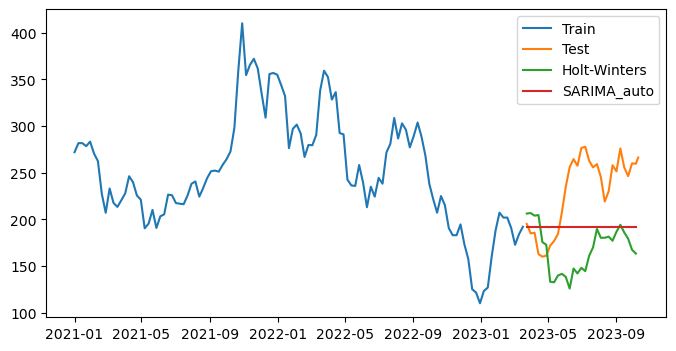

In [46]:
plt.figure(figsize = (8, 4))
plt.plot(train['close'], label = 'Train')
plt.plot(test['close'], label = 'Test')
plt.plot(df_preds['hw'], label = 'Holt-Winters')
plt.plot(df_preds['sarima_auto'], label = 'SARIMA_auto')

plt.legend(loc = 'best');

In [47]:
# Score the model: RMSE
# test['close'] has 30 values but df_preds['sarima_auto'] has 29 values and needs to be a padded array:

# Calculate the number of values to pad
num_to_pad = len(test['close']) - len(df_preds['sarima_auto'])

# Pad df_preds['sarima_auto'] with NaN values (or any other appropriate value)
padded_array = np.pad(df_preds['sarima_auto'], (0, num_to_pad), mode='constant', constant_values=np.nan)

# Calculate RMSE while ignoring NaN values
def rmse_ignore_nan(y_true, y_pred):
    mask = ~np.isnan(y_true)
    mse = ((y_true[mask] - y_pred[mask]) ** 2).mean()
    return np.sqrt(mse)

rmse = rmse_ignore_nan(test['close'], padded_array)
rmse

53.56393578188468

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  116
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -509.488
Date:                Tue, 10 Oct 2023   AIC                           1020.977
Time:                        12:29:18   BIC                           1023.722
Sample:                    01-01-2021   HQIC                          1022.091
                         - 03-17-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       412.7421     46.234      8.927      0.000     322.126     503.358
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                 2.98
Prob(Q):                              0.32   Prob(JB):                         0.23
Heteroskedasticity (H):               1.82   Skew:                             0.05
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A SARIMA model summary typically provides information about the model's fit to the time series data and the estimated model parameters. Its key elements include: 

1. The AIC is ~1021 and the BIC is 1024. These are both higher than the SES and HW models, indicating that the SARIMA model is a poorer fit based on these measures.
1. Ljung-Box Q-Statistics: These statistics are used to test the null hypothesis of no autocorrelation in the model residuals at different lags. Low p-values for these tests suggest that autocorrelation exists in the residuals, indicating that the model may need further refinement.

---

## Next steps: SARIMAX

SARIMAX, or Seasonal Autoregressive Integrated Moving Average with Exogenous Variables, is a time series forecasting model that extends the SARIMA framework by incorporating external or exogenous variables. It enables the inclusion of additional factors, such as economic indicators or environmental variables, to enhance the model's predictive capabilities by accounting for their impact on the time series of interest.

This model is recommended for further study to improve the predictive power of the TSLA closing price time series forecasting.